In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections as collections 
import os

from collections import Counter    
from mlxtend.frequent_patterns import apriori, association_rules

import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

anime = pd.read_csv('anime_with_genre_separated.csv')
users = pd.read_csv('users_cleaned_with_location.csv')
anime_list = pd.read_csv('animelists_cleaned.csv')

In [3]:
anime = anime.drop(columns=['title_english', 'rating','status','Unnamed: 0','title_japanese','title_synonyms','image_url','licensor','premiered','broadcast','related',
 'producer','members','background','airing','aired','aired_string','opening_theme','ending_theme','scored_by','aired_from_year'])



In [4]:
users = users.drop(columns=['Unnamed: 0','location','user_plantowatch','stats_rewatched','last_online','access_rank','join_date'])

In [5]:
import datetime as DT

now = pd.Timestamp('now')
users['birth_date'] = pd.to_datetime(users['birth_date'], format='%Y-%m-%d %H:%M:%S') 
users['birth_date'] = users['birth_date'].where(users['birth_date'] < now, users['birth_date'] -  np.timedelta64(100, 'Y')) 
users['age'] = (now - users['birth_date']).astype('<m8[Y]')    

In [6]:
#Create age brackets
users['age_range'] = pd.cut(users.age, 
                   bins=[0, 19, 24, 30, 39, 999], 
                   labels=['0-19', '20-24', '25-30', '31-39', '40+'],
                   include_lowest=True)

In [7]:
users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_days_spent_watching,gender,birth_date,stats_mean_score,stats_episodes,city,country,age,age_range
0,karthiga,2255153,3,49,1,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
1,Damonashu,37326,45,195,27,25,82.574306,Male,1991-08-01,6.15,4903,detroit,united states,29.0,25-30
2,bskai,228342,25,414,2,5,159.483333,Male,1990-12-14,8.27,9701,NaN,mexico,29.0,25-30
3,terune_uzumaki,327311,5,5,0,0,11.394444,Female,1998-08-24,9.70,697,NaN,malaysia,22.0,20-24
4,Bas_G,5015094,35,114,6,20,30.458333,Male,1999-10-24,7.86,1847,nederland,united states,21.0,20-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108706,isoann,797785,14,213,11,20,64.372222,Male,1997-01-13,8.03,3939,NaN,NaN,23.0,20-24
108707,bumcakee,1396285,13,116,5,9,41.365972,Female,1998-07-18,8.86,2537,california,united states,22.0,20-24
108708,Scarlet95,2478991,6,103,10,8,46.827083,Female,1995-10-17,7.40,2869,NaN,belgium,25.0,25-30
108709,Torasori,3975907,22,239,0,4,72.361111,Male,1998-11-18,8.98,4469,NaN,latvia,22.0,20-24


In [8]:
anime_list.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [9]:
anime_list = anime_list.drop(columns=['my_last_updated','my_tags','my_rewatching_ep','my_rewatching','my_finish_date','my_start_date'])
anime_list.head()                            
                            
                            

,username,anime_id,my_watched_episodes,my_score,my_status
0,karthiga,21,586,9,1
1,karthiga,59,26,7,2
2,karthiga,74,26,7,2
3,karthiga,120,26,7,2
4,karthiga,178,26,7,2


In [10]:
list(anime)

['anime_id',
 'title',
 'type',
 'source',
 'episodes',
 'duration',
 'score',
 'rank',
 'popularity',
 'favorites',
 'studio',
 'genre',
 'duration_min',
 'Ecchi',
 'Police',
 'Shoujo Ai',
 'Josei',
 'Fantasy',
 'Action',
 'Martial Arts',
 'Military',
 'Slice of Life',
 'Harem',
 'Music',
 'Drama',
 'Hentai',
 'Yaoi',
 'Supernatural',
 'Thriller',
 'Romance',
 'Shoujo',
 'Parody',
 'Adventure',
 'Magic',
 'Psychological',
 'School',
 'Samurai',
 'Historical',
 'Sports',
 'Vampire',
 'Yuri',
 'Super Power',
 'Space',
 'Comedy',
 'Shounen Ai',
 'Dementia',
 'Demons',
 'Game',
 'Sci-Fi',
 'Shounen',
 'Seinen',
 'Horror',
 'Cars',
 'Kids',
 'Mystery',
 'Mecha']

In [11]:
#Create episode duration brackets brackets
anime['duration_range'] = pd.cut(anime.duration_min, 
                   bins=[0, 10, 20, 25, 45, 61, 999], 
                   labels=['0-10min', '10-20min', '20-25min', '25-45', '45-60min','60min+'],
                   include_lowest=True)

In [12]:
anime.head()

,anime_id,title,type,source,episodes,duration,score,rank,popularity,favorites,...,Game,Sci-Fi,Shounen,Seinen,Horror,Cars,Kids,Mystery,Mecha,duration_range
0,11013,Inu x Boku SS,TV,Manga,12,24 min. per ep.,7.63,1274.0,231,2809,...,0,0,1,0,0,0,0,0,0,20-25min
1,2104,Seto no Hanayome,TV,Manga,26,24 min. per ep.,7.89,727.0,366,2579,...,0,0,1,0,0,0,0,0,0,20-25min
2,5262,Shugo Chara!! Doki,TV,Manga,51,24 min. per ep.,7.55,1508.0,1173,802,...,0,0,0,0,0,0,0,0,0,20-25min
3,721,Princess Tutu,TV,Original,38,16 min. per ep.,8.21,307.0,916,3344,...,0,0,0,0,0,0,0,0,0,10-20min
4,12365,Bakuman. 3rd Season,TV,Manga,25,24 min. per ep.,8.67,50.0,426,2082,...,0,0,1,0,0,0,0,0,0,20-25min


In [13]:
anime_list.head()

,username,anime_id,my_watched_episodes,my_score,my_status
0,karthiga,21,586,9,1
1,karthiga,59,26,7,2
2,karthiga,74,26,7,2
3,karthiga,120,26,7,2
4,karthiga,178,26,7,2


# Joining Tables

In [14]:
joined = pd.merge(anime, anime_list, on='anime_id')

In [15]:
joined = pd.merge(joined, users, on='username')

In [16]:
joined

,anime_id,title,type,source,episodes,duration,score,rank,popularity,favorites,...,user_dropped,user_days_spent_watching,gender,birth_date,stats_mean_score,stats_episodes,city,country,age,age_range
0,11013,Inu x Boku SS,TV,Manga,12,24 min. per ep.,7.63,1274.0,231,2809,...,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
1,2104,Seto no Hanayome,TV,Manga,26,24 min. per ep.,7.89,727.0,366,2579,...,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
2,5262,Shugo Chara!! Doki,TV,Manga,51,24 min. per ep.,7.55,1508.0,1173,802,...,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
3,721,Princess Tutu,TV,Original,38,16 min. per ep.,8.21,307.0,916,3344,...,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
4,12365,Bakuman. 3rd Season,TV,Manga,25,24 min. per ep.,8.67,50.0,426,2082,...,0,55.091667,Female,1990-04-29,7.43,3391,NaN,india,30.0,25-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284025,47,Akira,Movie,Manga,1,2 hr. 4 min.,8.16,352.0,198,5029,...,0,0.694444,Female,1994-01-26,0.00,36,tallinn,estonia,26.0,25-30
31284026,1629,Devilman Lady,TV,Manga,26,25 min. per ep.,6.83,4180.0,3423,70,...,0,0.694444,Female,1994-01-26,0.00,36,tallinn,estonia,26.0,25-30
31284027,1835,Ryuusei no Rockman,TV,Game,55,10 min. per ep.,7.23,2696.0,3969,73,...,0,2.310417,Male,1990-06-06,10.00,202,NaN,NaN,30.0,25-30
31284028,1728,Super GALS! Kotobuki Ran,TV,Manga,52,24 min. per ep.,7.52,1587.0,3384,152,...,0,0.866667,Female,1993-09-26,9.00,52,NaN,NaN,27.0,25-30


In [17]:
animeXgenre = joined[['anime_id','user_id','username','age_range', 'Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',
       'Action', 'Martial Arts', 'Military', 'Slice of Life', 'Harem', 'Music',
       'Drama', 'Hentai', 'Yaoi', 'Supernatural', 'Thriller', 'Romance',
       'Shoujo', 'Parody', 'Adventure', 'Magic', 'Psychological', 'School',
       'Samurai', 'Historical', 'Sports', 'Vampire', 'Yuri', 'Super Power',
       'Space', 'Comedy', 'Shounen Ai', 'Dementia', 'Demons', 'Game', 'Sci-Fi',
       'Shounen', 'Seinen', 'Horror', 'Cars', 'Kids', 'Mystery', 'Mecha']].copy()

In [18]:
genre_list_df = joined[['age_range', 'Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',
       'Action', 'Martial Arts', 'Military', 'Slice of Life', 'Harem', 'Music',
       'Drama', 'Hentai', 'Yaoi', 'Supernatural', 'Thriller', 'Romance',
       'Shoujo', 'Parody', 'Adventure', 'Magic', 'Psychological', 'School',
       'Samurai', 'Historical', 'Sports', 'Vampire', 'Yuri', 'Super Power',
       'Space', 'Comedy', 'Shounen Ai', 'Dementia', 'Demons', 'Game', 'Sci-Fi',
       'Shounen', 'Seinen', 'Horror', 'Cars', 'Kids', 'Mystery', 'Mecha']].copy()
#pd.pivot_table(animeXgenre, values=genre_list, index=genre_list,columns=['age_range'], aggfunc=np.sum)

In [19]:
ageXgenre = genre_list_df.groupby(['age_range'])['Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',
       'Action', 'Martial Arts', 'Military', 'Slice of Life', 'Harem', 'Music',
       'Drama', 'Hentai', 'Yaoi', 'Supernatural', 'Thriller', 'Romance',
       'Shoujo', 'Parody', 'Adventure', 'Magic', 'Psychological', 'School',
       'Samurai', 'Historical', 'Sports', 'Vampire', 'Yuri', 'Super Power',
       'Space', 'Comedy', 'Shounen Ai', 'Dementia', 'Demons', 'Game', 'Sci-Fi',
       'Shounen', 'Seinen', 'Horror', 'Cars', 'Kids', 'Mystery', 'Mecha'].sum()


<ipython-input-19-a53d4484c63f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ageXgenre = genre_list_df.groupby(['age_range'])['Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',


In [20]:
ageXgenre

,Ecchi,Police,Shoujo Ai,Josei,Fantasy,Action,Martial Arts,Military,Slice of Life,Harem,...,Demons,Game,Sci-Fi,Shounen,Seinen,Horror,Cars,Kids,Mystery,Mecha
age_range,,,,,,,,,,,,,,,,,,,,,
0-19,105728,14743,8659,9506,236180,355657,21657,42320,158949,79521,...,40527,36324,141747,220253,85290,47971,1501,12211,112503,36925
20-24,1042068,145220,83529,109220,2158107,3409564,222057,431683,1454135,793137,...,383479,287127,1480975,1972982,812726,451692,18034,111979,1080897,421929
25-30,1804565,296768,165658,223843,3850989,6216709,491436,913280,2414472,1307650,...,666584,409237,3044200,3524258,1359155,805971,38531,249142,1914040,1007841
31-39,737055,161589,77325,93314,1623000,2682736,238118,483346,932123,485249,...,274994,142048,1546902,1481619,572312,362704,22771,83913,760921,584483
40+,56164,13293,5791,5916,108382,182449,15431,35902,65819,36298,...,19003,9329,116719,95548,41299,25698,1731,3652,49464,45925


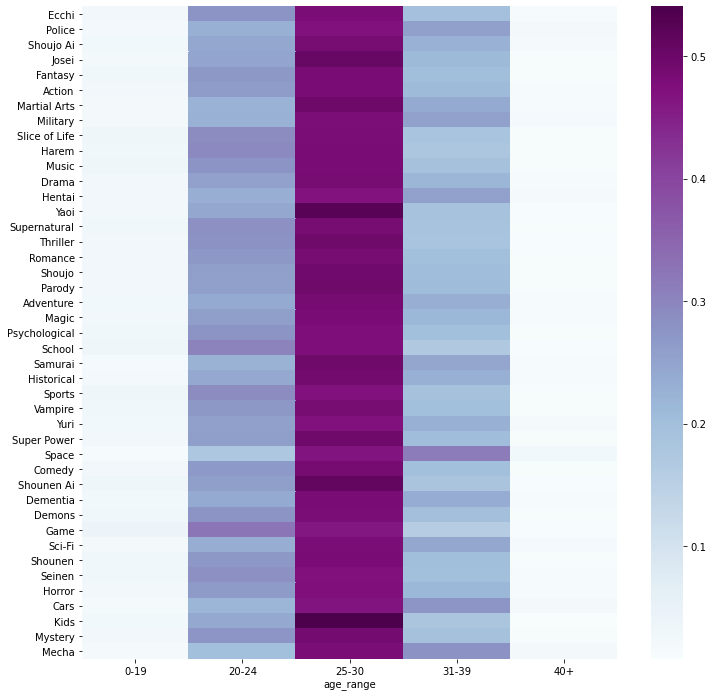

In [21]:
df = ageXgenre.div(ageXgenre.sum(axis=0), axis=1).transpose()
fig = plt.figure(figsize=(12,12))
sns.heatmap(df, cmap='BuPu')

In [22]:
animeXgenre

,anime_id,user_id,username,age_range,Ecchi,Police,Shoujo Ai,Josei,Fantasy,Action,...,Demons,Game,Sci-Fi,Shounen,Seinen,Horror,Cars,Kids,Mystery,Mecha
0,11013,2255153,karthiga,25-30,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2104,2255153,karthiga,25-30,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5262,2255153,karthiga,25-30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,721,2255153,karthiga,25-30,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12365,2255153,karthiga,25-30,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284025,47,336452,Ak-47,25-30,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
31284026,1629,336452,Ak-47,25-30,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
31284027,1835,110255,Beast-Master,25-30,0,0,0,0,0,1,...,0,1,1,1,0,0,0,0,0,0
31284028,1728,290011,AlainaCuyler,25-30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
ageXanime = joined[['anime_id','user_id', 'username','age_range']].copy()

In [24]:
ageXanime

,anime_id,user_id,username,age_range
0,11013,2255153,karthiga,25-30
1,2104,2255153,karthiga,25-30
2,5262,2255153,karthiga,25-30
3,721,2255153,karthiga,25-30
4,12365,2255153,karthiga,25-30
...,...,...,...,...
31284025,47,336452,Ak-47,25-30
31284026,1629,336452,Ak-47,25-30
31284027,1835,110255,Beast-Master,25-30
31284028,1728,290011,AlainaCuyler,25-30


In [25]:
list(joined)

['anime_id',
 'title',
 'type',
 'source',
 'episodes',
 'duration',
 'score',
 'rank',
 'popularity',
 'favorites',
 'studio',
 'genre',
 'duration_min',
 'Ecchi',
 'Police',
 'Shoujo Ai',
 'Josei',
 'Fantasy',
 'Action',
 'Martial Arts',
 'Military',
 'Slice of Life',
 'Harem',
 'Music',
 'Drama',
 'Hentai',
 'Yaoi',
 'Supernatural',
 'Thriller',
 'Romance',
 'Shoujo',
 'Parody',
 'Adventure',
 'Magic',
 'Psychological',
 'School',
 'Samurai',
 'Historical',
 'Sports',
 'Vampire',
 'Yuri',
 'Super Power',
 'Space',
 'Comedy',
 'Shounen Ai',
 'Dementia',
 'Demons',
 'Game',
 'Sci-Fi',
 'Shounen',
 'Seinen',
 'Horror',
 'Cars',
 'Kids',
 'Mystery',
 'Mecha',
 'duration_range',
 'username',
 'my_watched_episodes',
 'my_score',
 'my_status',
 'user_id',
 'user_watching',
 'user_completed',
 'user_onhold',
 'user_dropped',
 'user_days_spent_watching',
 'gender',
 'birth_date',
 'stats_mean_score',
 'stats_episodes',
 'city',
 'country',
 'age',
 'age_range']

In [26]:
joined_1 = joined.drop(['city'], axis=1)

In [27]:
joined_1 = joined.dropna(axis=0)

In [28]:
df = joined_1.drop(['Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',
       'Action', 'Martial Arts', 'Military', 'Slice of Life', 'Harem', 'Music',
       'Drama', 'Hentai', 'Yaoi', 'Supernatural', 'Thriller', 'Romance',
       'Shoujo', 'Parody', 'Adventure', 'Magic', 'Psychological', 'School',
       'Samurai', 'Historical', 'Sports', 'Vampire', 'Yuri', 'Super Power',
       'Space', 'Comedy', 'Shounen Ai', 'Dementia', 'Demons', 'Game', 'Sci-Fi',
       'Shounen', 'Seinen', 'Horror', 'Cars', 'Kids', 'Mystery', 'Mecha'], axis=1)

In [29]:
df = df.drop(['title','duration','username','birth_date'], axis=1)

In [30]:
list(df)

['anime_id',
 'type',
 'source',
 'episodes',
 'score',
 'rank',
 'popularity',
 'favorites',
 'studio',
 'genre',
 'duration_min',
 'duration_range',
 'my_watched_episodes',
 'my_score',
 'my_status',
 'user_id',
 'user_watching',
 'user_completed',
 'user_onhold',
 'user_dropped',
 'user_days_spent_watching',
 'gender',
 'stats_mean_score',
 'stats_episodes',
 'city',
 'country',
 'age',
 'age_range']

In [31]:
genres = joined_1[['Ecchi', 'Police', 'Shoujo Ai', 'Josei', 'Fantasy',
       'Action', 'Martial Arts', 'Military', 'Slice of Life', 'Harem', 'Music',
       'Drama', 'Hentai', 'Yaoi', 'Supernatural', 'Thriller', 'Romance',
       'Shoujo', 'Parody', 'Adventure', 'Magic', 'Psychological', 'School',
       'Samurai', 'Historical', 'Sports', 'Vampire', 'Yuri', 'Super Power',
       'Space', 'Comedy', 'Shounen Ai', 'Dementia', 'Demons', 'Game', 'Sci-Fi',
       'Shounen', 'Seinen', 'Horror', 'Cars', 'Kids', 'Mystery', 'Mecha']].copy()
genres.head()

,Ecchi,Police,Shoujo Ai,Josei,Fantasy,Action,Martial Arts,Military,Slice of Life,Harem,...,Demons,Game,Sci-Fi,Shounen,Seinen,Horror,Cars,Kids,Mystery,Mecha
7872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7873,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7874,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7876,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.dtypes

anime_id                       int64
type                          object
source                        object
episodes                       int64
score                        float64
rank                         float64
popularity                     int64
favorites                      int64
studio                        object
genre                         object
duration_min                 float64
duration_range              category
my_watched_episodes            int64
my_score                       int64
my_status                      int64
user_id                        int64
user_watching                  int64
user_completed                 int64
user_onhold                    int64
user_dropped                   int64
user_days_spent_watching     float64
gender                        object
stats_mean_score             float64
stats_episodes                 int64
city                          object
country                       object
age                          float64
a

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

df1hot = MultiColumnLabelEncoder(columns = ['anime_id', 'type', 'source', 'episodes', 'score', 'rank', 'popularity',
       'favorites', 'studio', 'genre', 'duration_min', 'duration_range',
       'my_watched_episodes', 'my_score', 'my_status', 'user_id',
       'user_watching', 'user_completed', 'user_onhold', 'user_dropped',
       'user_days_spent_watching', 'gender', 'stats_mean_score',
       'stats_episodes', 'city', 'country', 'age', 'age_range']).fit_transform(df)
df1hot

,anime_id,type,source,episodes,score,rank,popularity,favorites,studio,genre,...,user_onhold,user_dropped,user_days_spent_watching,gender,stats_mean_score,stats_episodes,city,country,age,age_range
7872,3260,5,6,12,374,1021,215,929,134,2003,...,2,49,20436,1,95,4132,2594,124,18,2
7873,1677,5,5,24,383,874,302,684,226,492,...,2,49,20436,1,95,4132,2594,124,18,2
7874,2131,5,6,11,435,254,859,274,226,2595,...,2,49,20436,1,95,4132,2594,124,18,2
7875,2617,5,6,26,431,286,69,1158,226,1902,...,2,49,20436,1,95,4132,2594,124,18,2
7876,3558,5,6,13,382,895,86,1004,99,2959,...,2,49,20436,1,95,4132,2594,124,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284019,221,5,6,72,487,26,285,1129,288,1981,...,0,0,537,1,570,82,3941,1,17,2
31284020,2289,5,6,26,481,40,595,683,288,1981,...,0,0,537,1,570,82,3941,1,17,2
31284023,444,5,6,38,402,564,900,669,592,2097,...,0,0,60,0,570,19,4084,124,17,2
31284025,28,0,6,1,427,317,185,1039,603,814,...,0,0,86,0,0,17,3848,39,14,2


# Decision Tree
Test 1: All variables --> predict age_range

In [37]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [38]:
df1hot_wGenre = pd.merge(genres, df1hot, left_index=True, right_index=True)

In [98]:
#Define features

X = df1hot.drop(['favorites','genre','duration_min','anime_id','age_range', 'user_id','gender','city','country','age','score','rank','popularity','user_watching','user_onhold','user_completed','user_dropped','user_days_spent_watching','my_status','my_score','my_watched_episodes','stats_mean_score','stats_episodes'], axis=1)

In [140]:
#Define Class Variables
y = df1hot[['gender']]
#y = df1hot[['age_range']]
#y = df1hot[['country']]

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [142]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [143]:
y_pred = classifier.predict(X_test)

In [144]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  24852  360863       0]
 [  15882 1310510       1]
 [    393    8785       0]]
              precision    recall  f1-score   support

           0       0.60      0.06      0.12    385715
           1       0.78      0.99      0.87   1326393
           2       0.00      0.00      0.00      9178

    accuracy                           0.78   1721286
   macro avg       0.46      0.35      0.33   1721286
weighted avg       0.74      0.78      0.70   1721286



In [49]:
X

,Ecchi,Police,Shoujo Ai,Josei,Fantasy,Action,Martial Arts,Military,Slice of Life,Harem,...,Mecha,anime_id,type,source,episodes,favorites,studio,genre,duration_min,duration_range
7872,0,0,0,0,0,0,0,0,0,0,...,0,3260,5,6,12,929,134,2003,55,2
7873,0,0,0,0,1,1,0,0,0,0,...,0,1677,5,5,24,684,226,492,55,2
7874,0,0,0,1,0,0,0,0,1,0,...,0,2131,5,6,11,274,226,2595,54,2
7875,0,0,0,0,0,0,0,0,0,0,...,0,2617,5,6,26,1158,226,1902,55,2
7876,0,0,0,0,0,0,0,0,1,0,...,0,3558,5,6,13,1004,99,2959,55,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284019,0,0,0,0,0,0,0,0,0,0,...,0,221,5,6,72,1129,288,1981,54,2
31284020,0,0,0,0,0,0,0,0,0,0,...,0,2289,5,6,26,683,288,1981,54,2
31284023,0,0,0,0,0,0,0,0,0,0,...,0,444,5,6,38,669,592,2097,55,2
31284025,0,0,0,0,0,1,0,1,0,0,...,0,28,0,6,1,1039,603,814,155,5


[Text(819.2475997124441, 1072.1000000000001, 'X[3] <= 33.5\ngini = 0.069\nsamples = 1721286\nvalue = [61542, 1659743, 1]'),
 Text(331.43784451959436, 1041.9, 'X[6] <= 1277.5\ngini = 0.056\nsamples = 1575604\nvalue = [45071, 1530532, 1]'),
 Text(122.53914123209083, 1011.7, 'X[2] <= 12.5\ngini = 0.023\nsamples = 671208\nvalue = [7867, 663341, 0]'),
 Text(66.57609693722681, 981.5, 'X[5] <= 53.5\ngini = 0.018\nsamples = 641156\nvalue = [5742, 635414, 0]'),
 Text(33.062651772705195, 951.3000000000001, 'X[0] <= 2571.5\ngini = 0.079\nsamples = 60471\nvalue = [2482, 57989, 0]'),
 Text(27.28120446818844, 921.1, 'X[0] <= 2511.0\ngini = 0.217\nsamples = 18061\nvalue = [2234, 15827, 0]'),
 Text(24.390480815930065, 890.9000000000001, 'X[4] <= 237.0\ngini = 0.116\nsamples = 16870\nvalue = [1043, 15827, 0]'),
 Text(21.499757163671685, 860.7, 'X[4] <= 162.5\ngini = 0.251\nsamples = 7104\nvalue = [1043, 6061, 0]'),
 Text(15.71830985915493, 830.5, 'X[0] <= 1903.5\ngini = 0.114\nsamples = 5977\nvalue = [

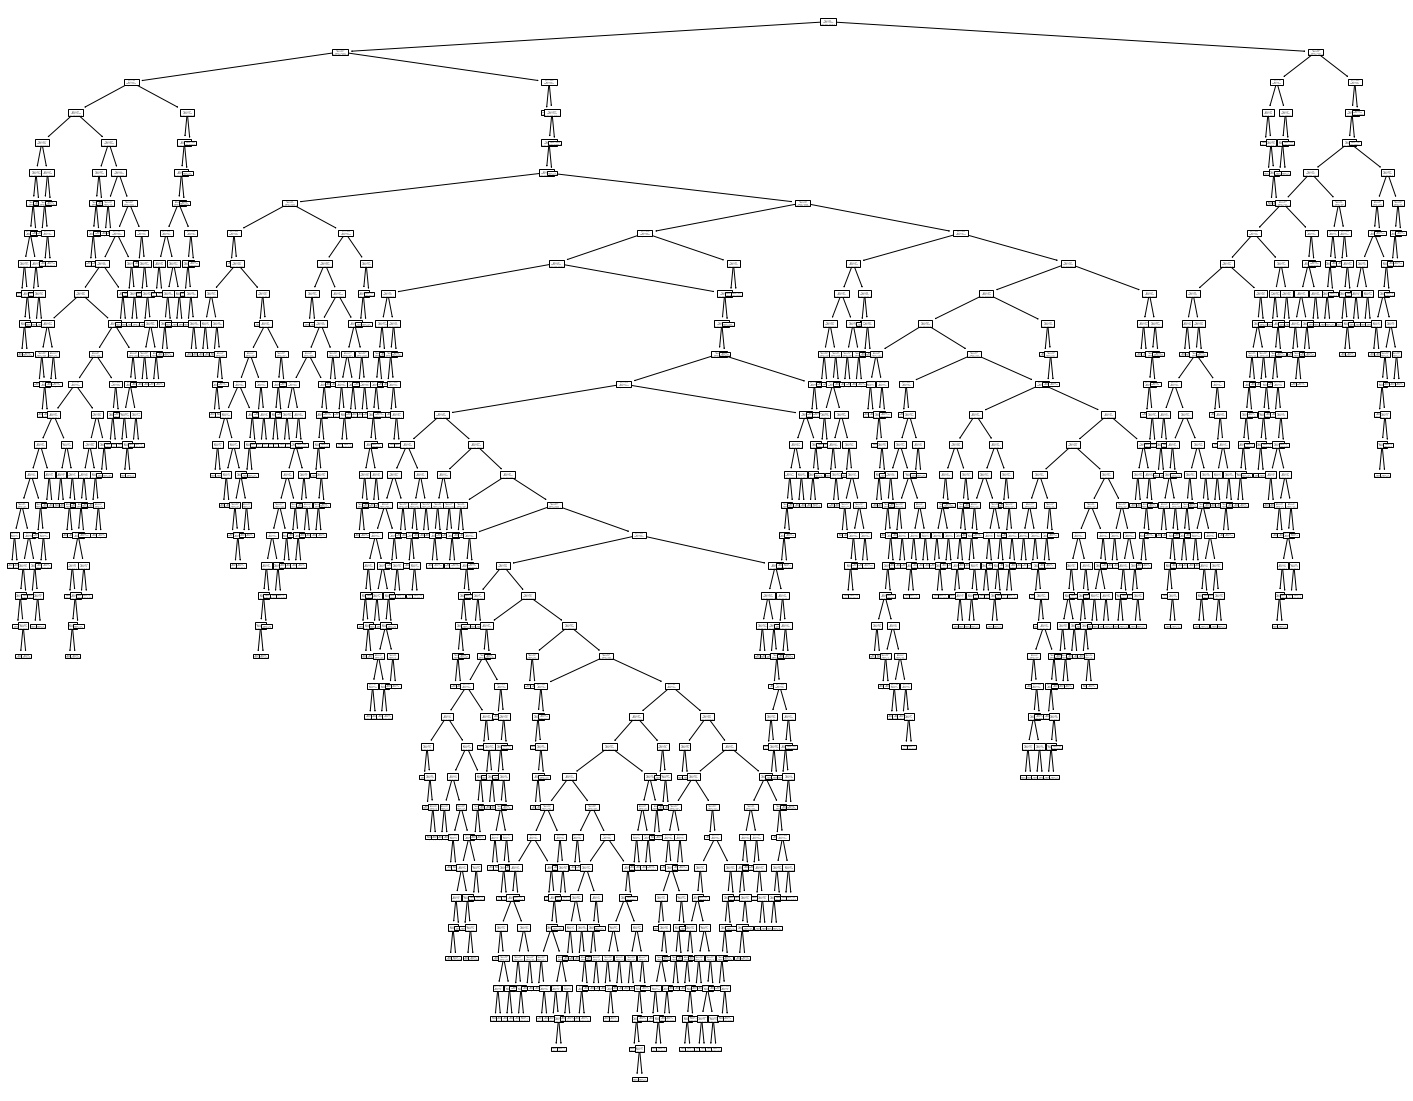

In [54]:
fig = plt.figure(figsize=(25,20))
gender_tree = classifier.fit(X_test, y_pred)
tree.plot_tree(gender_tree) 

In [71]:
df1hot_X = df1hot.drop(['favorites','anime_id', 'user_id','gender','city','country','age','score','rank','popularity','user_watching','user_onhold','user_completed','user_dropped','user_days_spent_watching','my_status','my_score','my_watched_episodes','stats_mean_score','stats_episodes'], axis=1)


In [119]:
y

,age_range
7872,2
7873,2
7874,2
7875,2
7876,2
...,...
31284019,2
31284020,2
31284023,2
31284025,2


In [64]:
X

,type,source,episodes,favorites,studio,genre,duration_min,duration_range
7872,5,6,12,929,134,2003,55,2
7873,5,5,24,684,226,492,55,2
7874,5,6,11,274,226,2595,54,2
7875,5,6,26,1158,226,1902,55,2
7876,5,6,13,1004,99,2959,55,2
...,...,...,...,...,...,...,...,...
31284019,5,6,72,1129,288,1981,54,2
31284020,5,6,26,683,288,1981,54,2
31284023,5,6,38,669,592,2097,55,2
31284025,0,6,1,1039,603,814,155,5


In [80]:
df1hot_X

,type,source,episodes,studio,genre,duration_min,duration_range,age_range
7872,5,6,12,134,2003,55,2,2
7873,5,5,24,226,492,55,2,2
7874,5,6,11,226,2595,54,2,2
7875,5,6,26,226,1902,55,2,2
7876,5,6,13,99,2959,55,2,2
...,...,...,...,...,...,...,...,...
31284019,5,6,72,288,1981,54,2,2
31284020,5,6,26,288,1981,54,2,2
31284023,5,6,38,592,2097,55,2,2
31284025,0,6,1,603,814,155,5,2


In [94]:
 X = df1hot_X.iloc[:, [0, 1]]

In [117]:
df1hot_X.iloc[1, 0]

5

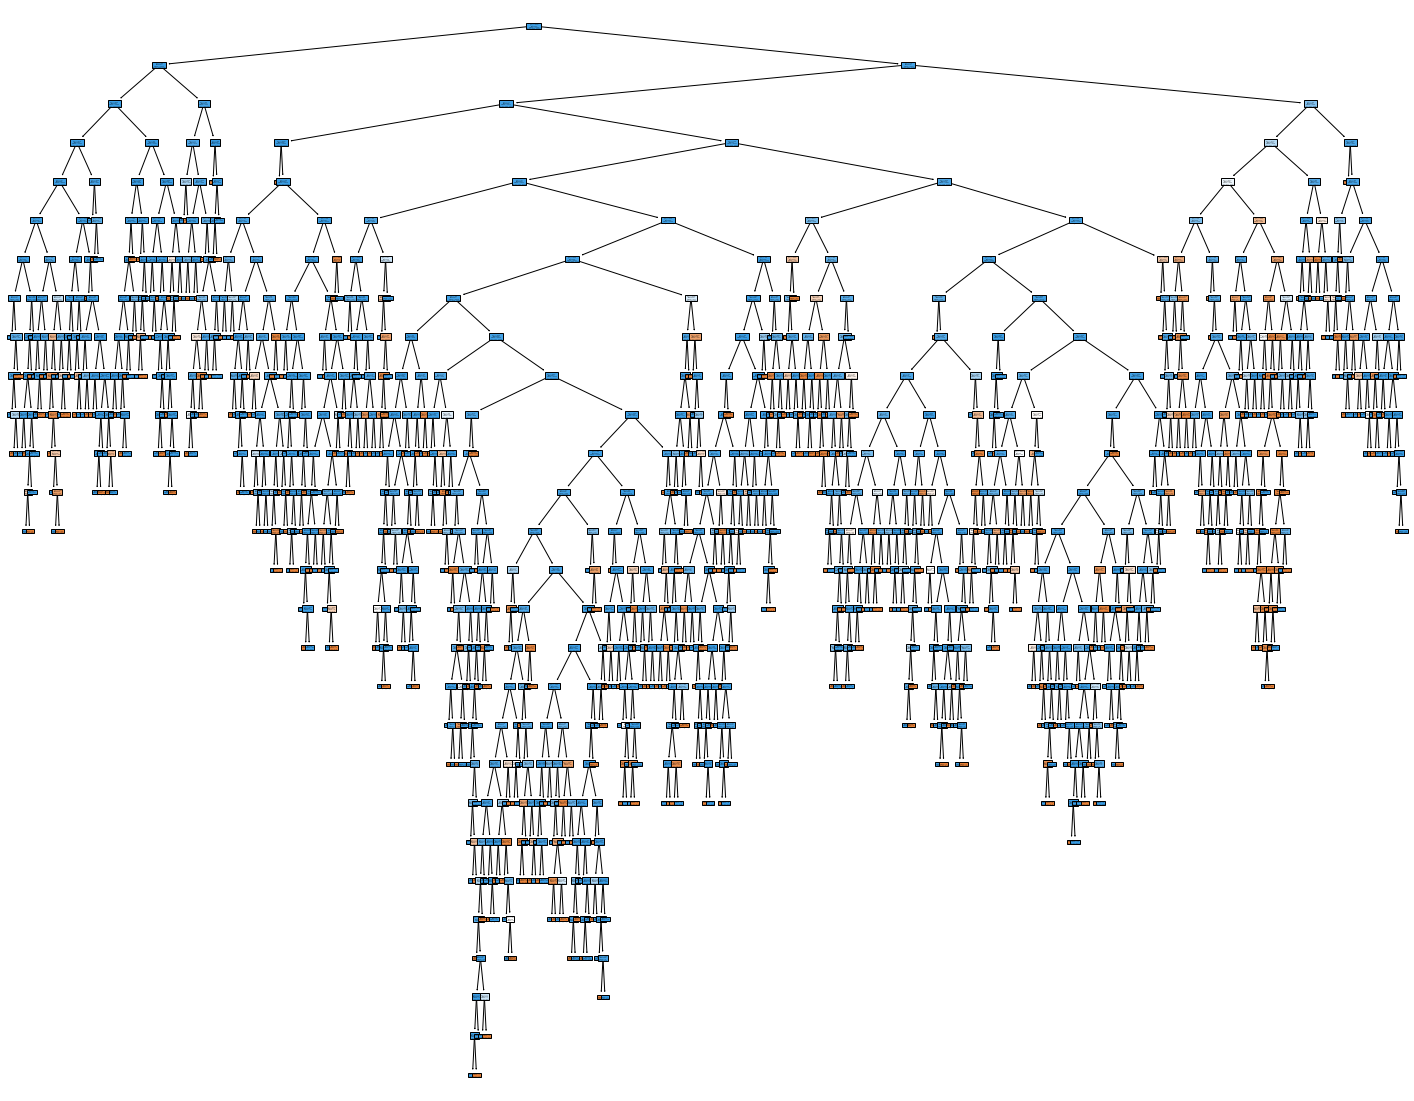

In [137]:
plt.figure(figsize=(25,20))
clf = DecisionTreeClassifier().fit(X_test, y_pred)
plot_tree(clf, filled=True)
plt.show()


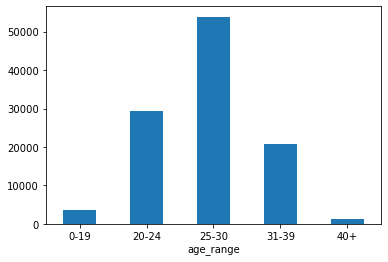

In [127]:
ages = users.groupby(['age_range'])['user_id'].count()
ax = ages.plot.bar(x='lab', y='val', rot=0)

In [130]:
anime_list1 = pd.read_csv('animelists_cleaned.csv')
anime_list1

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN
